In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

<a id="scikitlearn"></a>
## Scikit-Learn

Scikit-Learn is an incredibly powerful toolkit that allows data scientists to quickly build models from their data. Below we show a simple example of how to create a Linear Regression model.

# Linear Regression
LinearRegression is a simple machine learning model where the response y is modelled by a linear combination of the predictors in X.

The linear regression model implemented in the cuml library allows the user to change the fit_intercept, normalize and algorithm parameters.  cuML’s LinearRegression expects either a cuDF DataFrame or a NumPy matrix and provides 2 algorithms to fit a linear mode: lSVD and Eig . SVD is more stable, but Eig (default) is much more faster.

The Linear Regression function accepts the following parameters:
1. algorithm:‘eig’ or ‘svd’ (default = ‘eig’).  Eig uses a eigendecomposition of the covariance matrix, and is much faster. SVD is slower, but is guaranteed to be stable.
2. fit_intercept:boolean (default = True).  If True, LinearRegression tries to correct for the global mean of y. If False, the model expects that you have centered the data.
3. normalize:boolean (default = False).  If True, the predictors in X will be normalized by dividing by it’s L2 norm. If False, no scaling will be done.

The methods that can be used with the Linear regression are:
1. fit: Fit the model with X and y.
1. get_params: Sklearn style return parameter state
1. predict: Predicts the y for X.
1. set_params: Sklearn style set parameter state to dictionary of params.

In order to convert your dataset to cudf format please read the cudf documentation on https://rapidsai.github.io/projects/cudf/en/latest/. For additional information on the linear regression model please refer to the documentation on https://rapidsai.github.io/projects/cuml/en/latest/index.html

In [2]:
import numpy as np; print('NumPy Version:', np.__version__)


# create the relationship: y = 2.0 * x + 1.0
n_rows = 100000
w = 2.0
x = np.random.normal(loc=0, scale=1, size=(n_rows,))
b = 1.0
y = w * x + b

# add a bit of noise
noise = np.random.normal(loc=0, scale=2, size=(n_rows,))
y_noisy = y + noise

NumPy Version: 1.16.4


We can now visualize our data using the `matplotlib` library.

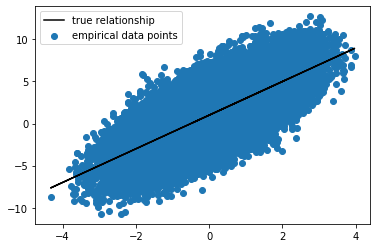

In [3]:
plt.scatter(x, y_noisy, label='empirical data points')
plt.plot(x, y, color='black', label='true relationship')
plt.legend()

We'll use the `LinearRegression` class from Scikit-Learn to instantiate a model and fit it to our data.

In [4]:
import sklearn; print('Scikit-Learn Version:', sklearn.__version__)
from sklearn.linear_model import LinearRegression

Scikit-Learn Version: 0.21.2


In [5]:
%%time
# instantiate and fit model
linear_regression = LinearRegression()
linear_regression.fit(np.expand_dims(x, 1), y)

CPU times: user 11.6 ms, sys: 737 µs, total: 12.3 ms
Wall time: 3.17 ms


In [6]:
# create new data and perform inference
inputs = np.linspace(start=-5, stop=5, num=1000000)

In [7]:
%%time
outputs = linear_regression.predict(np.expand_dims(inputs, 1))

CPU times: user 57.9 ms, sys: 46.8 ms, total: 105 ms
Wall time: 6.91 ms


Let's now visualize our empirical data points, the true relationship of the data, and the relationship estimated by the model. Looks pretty close!

/home/aaronmeurer/anaconda3/envs/rapids-tutorial/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/aaronmeurer/anaconda3/envs/rapids-tutorial/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


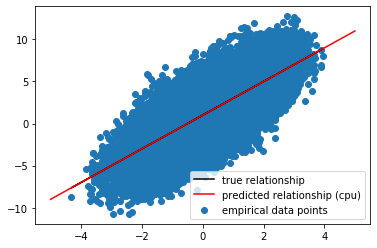

In [8]:
plt.scatter(x, y_noisy, label='empirical data points')
plt.plot(x, y, color='black', label='true relationship')
plt.plot(inputs, outputs, color='red', label='predicted relationship (cpu)')
plt.legend()

<a id="cuml"></a>
## cuML

The mathematical operations underlying many machine learning algorithms are often matrix multiplications. These types of operations are highly parallelizable and can be greatly accelerated using a GPU. cuML makes it easy to build machine learning models in an accelerated fashion while still using an interface nearly identical to Scikit-Learn. The below shows how to accomplish the same Linear Regression model but on a GPU.

First, let's convert our data from a NumPy representation to a cuDF representation.

In [9]:
import cudf; print('cuDF Version:', cudf.__version__)

# create a cuDF DataFrame
df = cudf.DataFrame({'x': x, 'y': y_noisy})
print(df.head())

cuDF Version: 0.7.2+0.g3ebd286.dirty
                      x                   y
0   -0.4572555570160816 -0.7235246399191512
1  0.014224659941215285  0.5902867722991301
2   -0.4173900955876541 -1.6477334116463211
3    1.1548890550556634   6.098716413363979
4   -0.8825854230163256  0.8853658301633196


Next, we'll load the GPU accelerated `LinearRegression` class from cuML, instantiate it, and fit it to our data.

In [10]:
import cuml; print('cuML Version:', cuml.__version__)
from cuml.linear_model import LinearRegression as LinearRegressionGPU

cuML Version: 0.7.0+0.g82f147b.dirty


In [11]:
%%time
# instantiate and fit model
linear_regression_gpu = LinearRegressionGPU()
linear_regression_gpu.fit(df[['x']], df['y'])

CPU times: user 294 ms, sys: 105 ms, total: 399 ms
Wall time: 398 ms


We can use this model to predict values for new data points, a step often called "inference" or "scoring". All model fitting and predicting steps are GPU accelerated.

In [12]:
# create new data and perform inference. inputs is the same data from the scikit-learn example above
new_data_df = cudf.DataFrame({'inputs': inputs})

In [13]:
%%time
outputs_gpu = linear_regression_gpu.predict(new_data_df[['inputs']])

CPU times: user 4.41 ms, sys: 72 µs, total: 4.48 ms
Wall time: 4.35 ms


Lastly, we can overlay our predicted relationship using our GPU accelerated Linear Regression model (green line) over our empirical data points (light blue circles), the true relationship (blue line), and the predicted relationship from a model built on the CPU (red line). We see that our GPU accelerated model's estimate of the true relationship (green line) is identical to the CPU based model's estimate of the true relationship (red line)!

/home/aaronmeurer/anaconda3/envs/rapids-tutorial/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/aaronmeurer/anaconda3/envs/rapids-tutorial/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


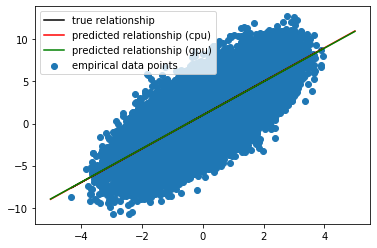

In [14]:
plt.scatter(x, y_noisy, label='empirical data points')
plt.plot(x, y, color='black', label='true relationship')
plt.plot(inputs, outputs, color='red', label='predicted relationship (cpu)')
plt.plot(inputs, outputs_gpu.to_array(), color='green', label='predicted relationship (gpu)')
plt.legend()